## Resting EEG Periodic, Aperiodic Measures and Cognitive Performance: Effects of Multimodal Lifestyle Intervention in Healthy Ageing *[WORKING TITLE]*

Created by Alicia J. Campbell

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
from tableone import TableOne
from scipy import stats
import os
import warnings
import patsy
import r_squared_calculator

warnings.simplefilter(action='ignore')

In [25]:
cwd = os.getcwd()

plots_dir = os.path.join(cwd, 'results', 'plots')
os.makedirs(plots_dir, exist_ok=True)

fnames = [
    'data/LEISURE_DEMO_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_CANTAB_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_SART_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_rsEEG_EC_T1_T2_T3_CONCAT_sensitivity.xlsx'
]

df = pd.DataFrame()
for i, fname in enumerate(fnames):
    df_t = pd.read_excel(os.path.join(cwd, fname))
    df_t.columns = df_t.columns.str.replace(" ", "_")
    df_t.columns = df_t.columns.str.replace("(", "_")
    df_t.columns = df_t.columns.str.replace(")", "_")
    df_t.columns = df_t.columns.str.replace("-", "_")
    if i == 0:
        df = df_t.copy()
    else:
        df = df.merge(df_t, on=['subject', 'tp'], how='outer')

### EXCLUSIONS

# drop subjects with no EEG
df = df.dropna(subset='EEG_date')

# drop IAF for subjects with no alpha peak
df.loc[(df['tp'] == 1) & (df['subject'].isin([61, 95, 97, 130])), 'IAF_fc'] = np.nan
df.loc[(df['tp'] == 2) & (df['subject'].isin([61, 65, 75, 80, 93])), 'IAF_fc'] = np.nan
df.loc[(df['tp'] == 3) & (df['subject'].isin([14, 75, 80, 93, 97, 130])), 'IAF_fc'] = np.nan

df.loc[(df['tp'] == 2) & (df['subject'].isin([93])), 'IAF_po'] = np.nan
df.loc[(df['tp'] == 3) & (df['subject'].isin([14, 93])), 'IAF_po'] = np.nan

# drop EEG data for subjects with negative exponent values
negative_po = df[df['exponent_po'] < 0][['subject', 'tp', 'exponent_po']]
negative_fc = df[df['exponent_fc'] < 0][['subject', 'tp', 'exponent_fc']]
print("Subjects dropped due to negative parieto-occipital exponent:")
print(negative_po)
print("\nSubjects dropped due to negative fronto-central exponent:")
print(negative_fc)

df.loc[df['exponent_po'] < 0, ['exponent_po', 'IAF_po', 'r2_po']] = np.nan
df.loc[df['exponent_fc'] < 0, ['exponent_fc', 'IAF_fc', 'r2_fc']] = np.nan

# # drop EEG data for subjects with specparam model fit r2 under 0.9
# bad_r2_po = df[df['r2_po'] < 0.9][['subject', 'tp', 'r2_po']]
# bad_r2_fc = df[df['r2_fc'] < 0.9][['subject', 'tp', 'r2_fc']]
# print("Subjects dropped due to r2 <0.9 parieto-occipital:")
# print(bad_r2_po)
# print("\nSubjects dropped due to r2 <0.9 fronto-central:")
# print(bad_r2_fc)

# df.loc[df['r2_fc'] < 0.9, ['exponent_fc', 'IAF_fc']] = np.nan
# df.loc[df['r2_po'] < 0.9, ['exponent_po', 'IAF_po']] = np.nan

# # drop EEG data for subjects with bad visual fits
# df.loc[(df['tp'] == 2) & (df['subject'] == 7), ['exponent_fc', 'IAF_fc']] = np.nan
# df.loc[(df['tp'] == 3) & (df['subject'].isin([7, 101])), ['exponent_fc', 'IAF_fc']] = np.nan

# Calculate mean and SD for r2_fc and r2_po by timepoint
for tp in [1, 2, 3]:
    print(f'\nTimepoint {tp}:')
    
    # Fronto-central R²
    fc_mean = df[df['tp']==tp]['r2_fc'].mean()
    fc_std = df[df['tp']==tp]['r2_fc'].std()
    print(f'R² Fronto-central: {fc_mean:.3f} ± {fc_std:.3f}')
    
    # Parieto-occipital R²
    po_mean = df[df['tp']==tp]['r2_po'].mean()
    po_std = df[df['tp']==tp]['r2_po'].std()
    print(f'R² Parieto-occipital: {po_mean:.3f} ± {po_std:.3f}')

for tp in [1, 2, 3]:
    print(f'tp={tp}')
    print(len(df[df['tp']==tp]))

Subjects dropped due to negative parieto-occipital exponent:
Empty DataFrame
Columns: [subject, tp, exponent_po]
Index: []

Subjects dropped due to negative fronto-central exponent:
    subject  tp  exponent_fc
16        7   2    -0.006624
17        7   3    -0.022648

Timepoint 1:
R² Fronto-central: 0.966 ± 0.040
R² Parieto-occipital: 0.982 ± 0.014

Timepoint 2:
R² Fronto-central: 0.966 ± 0.044
R² Parieto-occipital: 0.980 ± 0.014

Timepoint 3:
R² Fronto-central: 0.967 ± 0.034
R² Parieto-occipital: 0.975 ± 0.025
tp=1
99
tp=2
85
tp=3
69


In [26]:
df_dc = df.copy()
df_dc['gender_f'] = df_dc['gender_f'].map({0.0: 'M', 1.0: 'F'})
df_dc['handedness_r'] = df_dc['handedness_r'].map({0.0: 'L', 1.0: 'R'})

vars_all = {
    'age': 'Age', 
    'gender_f': 'Gender', 
    'handedness_r': 'Handedness', 
    'education': 'Education',
    'DMSPCAD': 'DMS PCAD', 
    'PALTEA': 'PALTEA',
    'RVPA': 'RVP A', 
    'SWMBE': 'SWMBE', 
    'd_prime': ["SART D'"], 
    'exponent_po': 'Parieto-occipital exponent', 
    'iaf_po': 'Parieto-occipital IAF', 
    'exponent_fc': 'Fronto-central exponent', 
    'iaf_fc': 'Fronto-central IAF'
}

# Print missing values
df_subset = df_dc[df_dc['tp']==1]
for column in vars_all.keys():
    missing = df_subset[df_subset[column].isna()]
    if len(missing) > 0:
        print(f"\nMissing values in {vars_all[column]}:")
        for _, row in missing.iterrows():
            print(f"Subject {row['subject']}")
            
vars_cat = ['handedness_r', 'gender_f']
vars_notnorm = ['education']

table = TableOne(
    # data
    data=df_subset,
    groupby='group_life',
    columns=list(vars_all.keys()),
    categorical=vars_cat,
    include_null=True,
    # visual
    rename=vars_all,
    decimals=1,
    label_suffix=True,
    missing=True,
    overall=True,
    # tests
    dip_test=True,
    normal_test=True,
    tukey_test=True,
    # stats
    nonnormal=vars_notnorm,
    htest_name=True,
    pval=True, 
    pval_adjust=None
)

# table.to_excel('results/descriptives_T1.xlsx')
display(table)

contingency = pd.crosstab(df_subset['group_life'], df_subset['handedness_r'])
_, pval = stats.fisher_exact(contingency)

print("Contingency Table:")
print(contingency)
print(f"\nFisher's exact test p-value: {pval:.3f}")


Missing values in ["SART D'"]:
Subject 94

Missing values in Parieto-occipital exponent:
Subject 29
Subject 36
Subject 118

Missing values in Parieto-occipital IAF:
Subject 29
Subject 36
Subject 118

Missing values in Fronto-central exponent:
Subject 29
Subject 36
Subject 118

Missing values in Fronto-central IAF:
Subject 29
Subject 36
Subject 118


Grouped by group_life                                                                                 
                                                      Missing           Overall               0.0               1.0 P-Value               Test
n                                                                            99                54                45                           
Age, mean (SD)                                              0        65.5 (8.3)        63.8 (8.6)        67.4 (7.6)   0.030  Two Sample T-test
Gender, n (%)                         F                               80 (80.8)         45 (83.3)         35 (77.8)   0.658        Chi-squared
                                      M                               19 (19.2)          9 (16.7)         10 (22.2)                           
Handedness, n (%)                     L                               13 (13.1)          7 (13.0)          6 (13.3)   1.000        Chi-squared
                                      R                               86 (86.9)         47 (87.0)         39 (86.7)                           
Education, median [Q1,Q3]                                   0  15.0 [12.5,17.0]  16.0 [12.2,18.0]  15.0 [13.0,17.0]   0.298     Kruskal-Wallis
DMS PCAD, mean (SD)                                         0       83.4 (12.0)       85.4 (11.3)       81.1 (12.5)   0.078  Two Sample T-test
PALTEA, mean (SD)                                           0       19.6 (14.6)       18.1 (14.1)       21.3 (15.2)   0.286  Two Sample T-test
RVP A, mean (SD)                                            0         0.9 (0.0)         0.9 (0.0)         0.9 (0.0)   0.635  Two Sample T-test
SWMBE, mean (SD)                                            0        17.5 (7.8)        16.5 (9.2)        18.7 (5.5)   0.146  Two Sample T-test
["SART D'"], mean (SD)                                      1         3.8 (0.6)         3.7 (0.7)         3.9 (0.6)   0.261  Two Sample T-test
Parieto-occipital exponent, mean (SD)                       3         0.9 (0.2)         0.9 (0.2)         0.9 (0.2)   0.871  Two Sample T-test
Parieto-occipital IAF, mean (SD)                            3         9.8 (1.2)         9.8 (1.2)         9.8 (1.1)   0.908  Two Sample T-test
Fronto-central exponent, mean (SD)                          3         0.9 (0.2)         0.9 (0.2)         0.9 (0.2)   0.570  Two Sample T-test
Fronto-central IAF, mean (SD)                               3         9.7 (1.4)         9.8 (1.4)         9.7 (1.4)   0.684  Two Sample T-test
[1] Hartigan's Dip Test reports possible
                                    multimodal distributions for: DMSPCAD, education.
[2] Normality test reports non-normal
                                    distributions for: education, exponent_po.

Contingency Table:
handedness_r  L   R
group_life         
0.0           7  47
1.0           6  39

Fisher's exact test p-value: 1.000


### LMMs

Fixed TP

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    DMSPCAD  
No. Observations:    237        Method:                REML     
No. Groups:          85         Scale:                 0.4785   
Min. group size:     2          Log-Likelihood:        -332.1082
Max. group size:     3          Converged:             Yes      
Mean group size:     2.8                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.038    0.155  0.242 0.809 -0.267  0.342
tp[T.2]                0.017    0.208  0.082 0.934 -0.390  0.425
tp[T.3]               -0.091    0.209 -0.435 0.664 -0.501  0.319
age_bas               -0.143    0.115 -1.247 0.212 -0.368  0.082
tp[T.2]:age_bas       -0.109    0.155 -0.703 0.482 -0.412  0.194
tp[T.3]:age_bas       -0.147    0.159 -

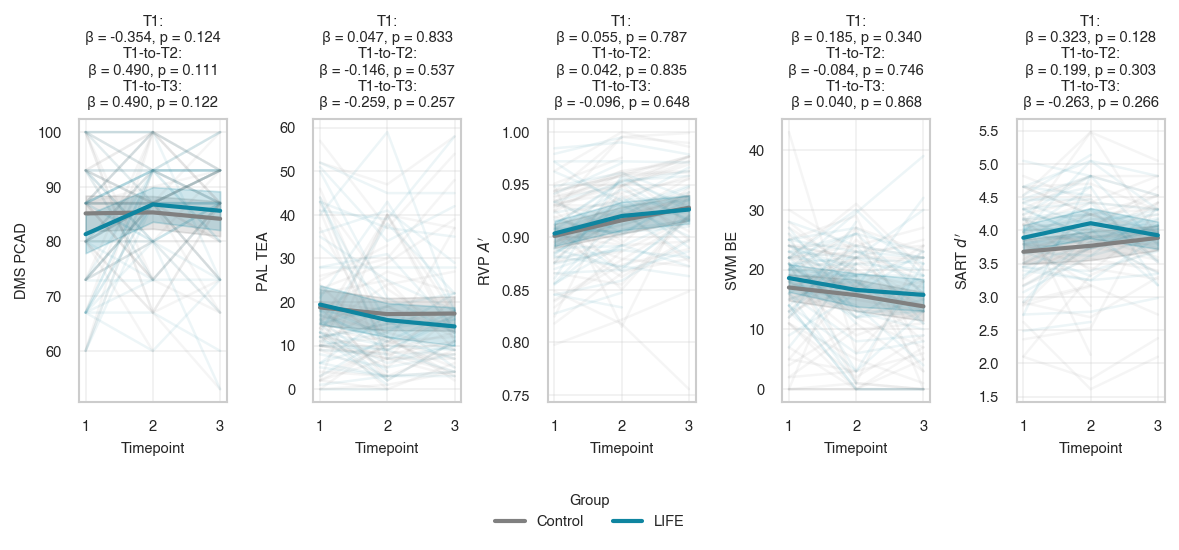

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   exponent_fc
No. Observations:    220       Method:               REML       
No. Groups:          82        Scale:                0.2578     
Min. group size:     2         Log-Likelihood:       -277.8472  
Max. group size:     3         Converged:            Yes        
Mean group size:     2.7                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             -0.097    0.142 -0.683 0.495 -0.375  0.181
tp[T.2]                0.174    0.129  1.344 0.179 -0.080  0.428
tp[T.3]                0.252    0.136  1.853 0.064 -0.014  0.519
age_bas               -0.209    0.107 -1.943 0.052 -0.419  0.002
tp[T.2]:age_bas        0.164    0.098  1.677 0.093 -0.028  0.356
tp[T.3]:age_bas        0.204    0.110  

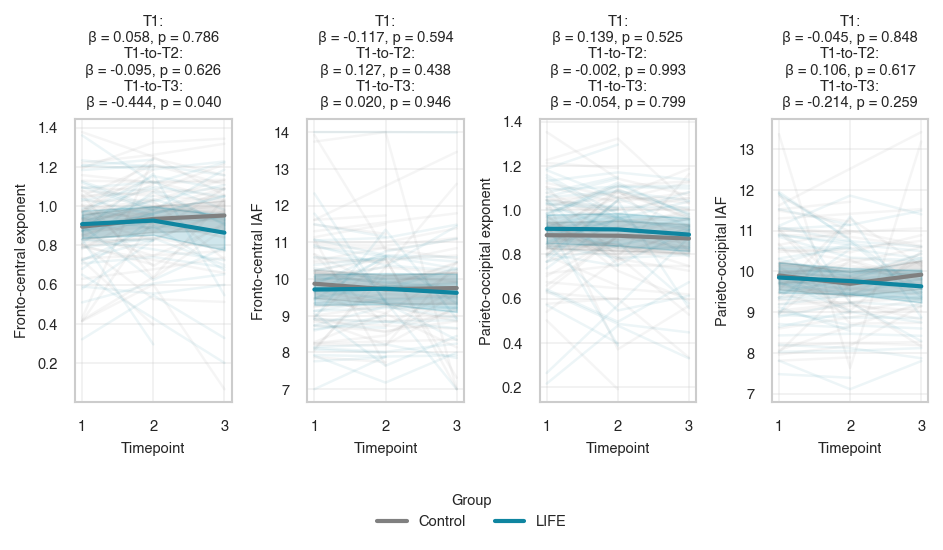

In [15]:
vars_dict = {
    'cog': {
        'DMSPCAD': 'DMS PCAD', 
        'PALTEA': 'PAL TEA', 
        'RVPA': "RVP $\\mathit{A'}$", 
        'SWMBE': 'SWM BE', 
        'd_prime': "SART $\\mathit{d'}$"
    },
    'eeg': {
         'exponent_fc': 'Fronto-central exponent', 
         'iaf_fc': 'Fronto-central IAF', 
         'exponent_po': 'Parieto-occipital exponent', 
         'iaf_po': 'Parieto-occipital IAF'
    }
}
colors = {'0.0': 'grey', '1.0': '#0F85A0FF'}   # '#5785C1FF'    '#CB7A5CFF'     '#0F85A0FF'
legend_dict = {0.0: 'Control', 1.0: 'LIFE'} 
sns.set_theme(font='Helvetica', context='paper', style='whitegrid')
plt.rc('grid', linestyle='-', alpha=0.3)
plt.rcParams.update({
    'font.size': 7, 'axes.titlesize': 7, 'axes.labelsize': 7, 'xtick.labelsize': 7,
    'ytick.labelsize': 7, 'legend.fontsize': 7, 'figure.dpi': 150
})

for type, vars in vars_dict.items():
    if type == 'cog':
        fig, axs = plt.subplots(1, 5, figsize=((40*5)/25.4, 80/25.4))
    else:
        fig, axs = plt.subplots(1, 4, figsize=((40*4)/25.4, 80/25.4))
    
    for i, (dv, dv_label) in enumerate(vars.items()):
        ax = axs[i]
            
        df_lme = df[['subject', 'tp', 'group_life', 'age', 'gender_f', 'education', 'handedness_r', dv]]
        df_lme = df_lme.sort_values(by=['subject', 'tp'])

        # keep only subjects with multiple timepoints and necessary data
        df_lme = df_lme.dropna()
        df_lme = df_lme[df_lme['subject'].isin(df_lme[df_lme['tp'] == 1]['subject'].unique())]
        df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]
        df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')
        df_lme['education_bas'] = df_lme.groupby('subject')['education'].transform('first')
        df_lme['tp'] = df_lme['tp'].astype('category')

        # zscore
        cols_z = ['age_bas', 'gender_f', 'education_bas', 'handedness_r', dv]
        orig_means, orig_stds = df_lme[cols_z].mean(), df_lme[cols_z].std()
        df_lme_z = df_lme.copy()
        df_lme_z[cols_z] = df_lme_z[cols_z].apply(stats.zscore)

        # Mixed-effects model with TP as a categorical predictor
        # formula = f"{dv} ~ age_bas + education_bas + gender_f + handedness_r + tp * group_life"
        formula = f"{dv} ~ tp * (age_bas + education_bas + gender_f + handedness_r + group_life)"
        model = smf.mixedlm(formula, data=df_lme_z, groups='subject', re_formula="~tp")
        results = model.fit()

        print(results.summary())

        # calc r2
        r2_marg, r2_cond = r_squared_calculator.calculate_r2_nakagawa(results)
    
        # Print the results
        print("\nNakagawa & Schielzeth R-squared values:")
        print(f"Marginal R² = {r2_marg:.3f}")
        print(f"Conditional R² = {r2_cond:.3f}\n")
            
        # dataframe for group and tp predictions
        pred_df = pd.DataFrame({
            'tp': np.repeat([1, 2, 3], 2),
            'group_life': np.tile([0.0, 1.0], 3)
        })
        for col in ['age_bas', 'education_bas', 'gender_f', 'handedness_r']:
            pred_df[col] = [df_lme_z[col].mean()] * 6

        pred_df['tp'] = pred_df['tp'].astype('category')
        pred_df['predicted'] = results.predict(pred_df)
        pred_df['predicted_orig'] = pred_df['predicted'] * orig_stds[dv] + orig_means[dv]

        # calculate confidence intervals
        design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=pred_df))
        prediction_var = np.diag(design_matrix @ results.cov_params().iloc[:18, :18] @ design_matrix.T) # change the :10 if different formula
        se = np.sqrt(prediction_var)
        pred_df['ci_lower'] = (pred_df['predicted'] - 1.96 * se) * orig_stds[dv] + orig_means[dv]
        pred_df['ci_upper'] = (pred_df['predicted'] + 1.96 * se) * orig_stds[dv] + orig_means[dv]

        ### plotting
        
        # spaghetti plot
        for subject, group in df_lme.groupby('subject'):
            group_color = colors[str(group['group_life'].iloc[0])]  # Get group color
            ax.plot(
                group['tp'], group[dv],
                alpha=0.075, color=group_color, label='_nolegend_'
            )

        # prediction plot
        for group in [0.0, 1.0]:
            group_data = pred_df[pred_df['group_life'] == group]
            ax.plot(group_data['tp'], group_data['predicted_orig'], 
                    label=legend_dict[group], linewidth=2, 
                    color=colors[str(group)])
            ax.fill_between(group_data['tp'], 
                            group_data['ci_lower'],
                            group_data['ci_upper'],
                            alpha=0.2, color=colors[str(group)])

        # annotations
        tp1_idx = results.model.exog_names.index('group_life')
        tp1_b, tp1_p = results.params[tp1_idx], results.pvalues[tp1_idx]
        tp1_ptext = '< 0.001' if tp1_p < 0.001 else f'= {tp1_p:.3f}'
        
        tp2_idx = results.model.exog_names.index('tp[T.2]:group_life')
        tp2_b, tp2_p = results.params[tp2_idx], results.pvalues[tp2_idx]
        tp2_ptext = '< 0.001' if tp2_p < 0.001 else f'= {tp2_p:.3f}'
        
        tp3_idx = results.model.exog_names.index('tp[T.3]:group_life')
        tp3_b, tp3_p = results.params[tp3_idx], results.pvalues[tp3_idx]
        tp3_ptext = '< 0.001' if tp3_p < 0.001 else f'= {tp3_p:.3f}'

        ax.set_title(
            f'T1:\nβ = {tp1_b:.3f}, p {tp1_ptext}\n'
            f'T1-to-T2:\nβ = {tp2_b:.3f}, p {tp2_ptext}\n'
            f'T1-to-T3:\nβ = {tp3_b:.3f}, p {tp3_ptext}'
        )

        ax.set_xlabel('Timepoint')
        ax.set_ylabel(dv_label)
    plt.tight_layout()
    plt.legend(loc='lower center', ncol=2, title='Group', frameon=False, title_fontsize=7,
               bbox_to_anchor=(0.5, -0.15), bbox_transform=fig.transFigure)
    # plt.savefig(os.path.join(plots_dir, f'LME_tp_{type}.pdf'), format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

Continuous time

            Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   DMSPCAD  
No. Observations:   237       Method:               REML     
No. Groups:         85        Scale:                0.7597   
Min. group size:    2         Log-Likelihood:       -332.0401
Max. group size:    3         Converged:            Yes      
Mean group size:    2.8                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.056    0.129  0.431 0.666 -0.197  0.308
time               -0.119    0.262 -0.454 0.650 -0.632  0.394
age_bas            -0.165    0.096 -1.721 0.085 -0.353  0.023
education_bas       0.055    0.096  0.576 0.565 -0.132  0.242
gender_f           -0.142    0.094 -1.502 0.133 -0.327  0.043
handedness_r       -0.080    0.097 -0.830 0.406 -0.269  0.109
group_life         -

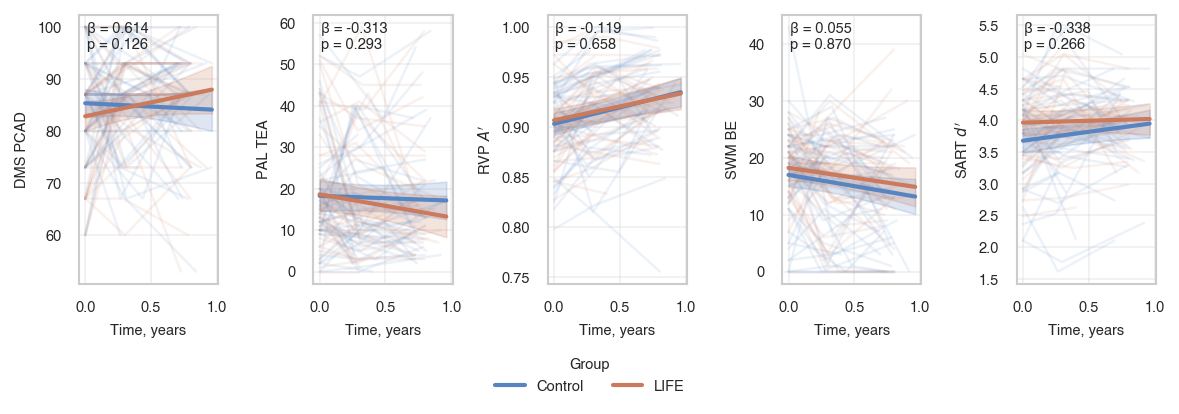

            Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  exponent_fc
No. Observations:   220      Method:              REML       
No. Groups:         82       Scale:               0.3293     
Min. group size:    2        Log-Likelihood:      -271.9831  
Max. group size:    3        Converged:           Yes        
Mean group size:    2.7                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept          -0.082    0.135 -0.611 0.541 -0.346  0.181
time                0.358    0.172  2.079 0.038  0.021  0.696
age_bas            -0.190    0.102 -1.865 0.062 -0.390  0.010
education_bas      -0.179    0.103 -1.741 0.082 -0.381  0.023
gender_f           -0.044    0.100 -0.445 0.657 -0.240  0.151
handedness_r       -0.087    0.102 -0.853 0.394 -0.288  0.113
group_life          

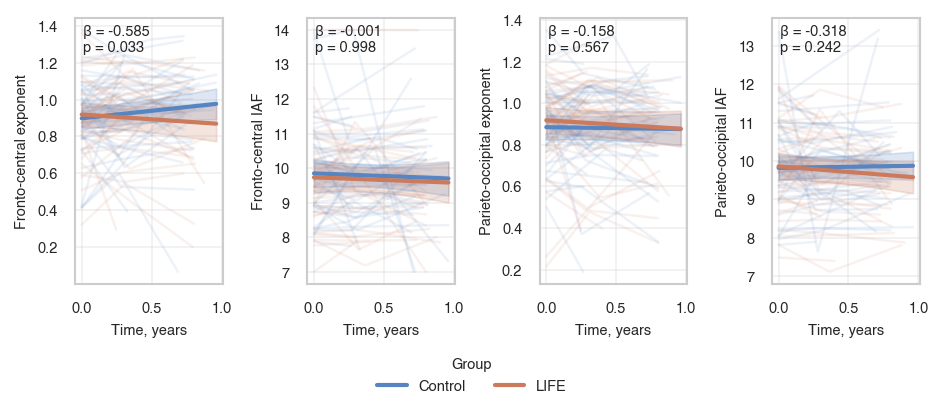

In [13]:
vars_dict = {
    'cog': {
        'DMSPCAD': 'DMS PCAD', 
        'PALTEA': 'PAL TEA', 
        'RVPA': "RVP $\\mathit{A'}$", 
        'SWMBE': 'SWM BE', 
        'd_prime': "SART $\\mathit{d'}$"
    },
    'eeg': {
         'exponent_fc': 'Fronto-central exponent', 
         'iaf_fc': 'Fronto-central IAF', 
         'exponent_po': 'Parieto-occipital exponent', 
         'iaf_po': 'Parieto-occipital IAF'
    }
}
colors = {'0.0': '#5785C1FF', '1.0': '#CB7A5CFF'} 
legend_dict = {0.0: 'Control', 1.0: 'LIFE'} 
sns.set_theme(font='Helvetica', context='paper', style='whitegrid')
plt.rc('grid', linestyle='-', alpha=0.3)
plt.rcParams.update({
    'font.size': 7, 'axes.titlesize': 7, 'axes.labelsize': 7, 'xtick.labelsize': 7,
    'ytick.labelsize': 7, 'legend.fontsize': 7, 'figure.dpi': 150
})

for type, vars in vars_dict.items():
    if type == 'cog':
        fig, axs = plt.subplots(1, 5, figsize=((40*5)/25.4, 60/25.4))
    else:
        fig, axs = plt.subplots(1, 4, figsize=((40*4)/25.4, 60/25.4))
    
    for i, (dv, dv_label) in enumerate(vars.items()):
        ax = axs[i]

        df_lme = df[[f'subject', 'tp', 'group_life', 'age', 'gender_f', 'education', 'handedness_r', dv]]

        df_lme = df_lme.sort_values(by=['subject', 'tp'])
        df_lme['time'] = df_lme.groupby('subject')['age'].transform(lambda x: x - x.iloc[0])
        df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')
        df_lme['education_bas'] = df_lme.groupby('subject')['education'].transform('first')
        
        df_lme = df_lme.dropna()
        df_lme = df_lme[df_lme['subject'].isin(df_lme[df_lme['tp'] == 1]['subject'].unique())]
        df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]

        # zscore
        cols_z = ['age_bas', 'gender_f', 'education_bas', 'handedness_r', dv]
        orig_means, orig_stds = df_lme[cols_z].mean(), df_lme[cols_z].std()
        df_lme_z = df_lme.copy()
        df_lme_z[cols_z] = df_lme_z[cols_z].apply(stats.zscore)
        
        # formula = f"{dv} ~ age_bas + education_bas + gender_f + handedness_r + time * group_life"
        formula = f"{dv} ~ time * (age_bas + education_bas + gender_f + handedness_r + group_life)"
        model = smf.mixedlm(formula, data=df_lme_z, groups='subject', re_formula='~time')
        results = model.fit()
        print(results.summary())

        # calc r2
        r2_marg, r2_cond = r_squared_calculator.calculate_r2_nakagawa(results)
    
        # Print the results
        print("\nNakagawa & Schielzeth R-squared values:")
        print(f"Marginal R² = {r2_marg:.3f}")
        print(f"Conditional R² = {r2_cond:.3f}\n")

        # dataframe for group predictions
        time_grid = np.linspace(df_lme['time'].min(), df_lme['time'].max(), 100)
        predictions = []
        for group_life in df_lme['group_life'].unique():
            # calculate mean
            pred_df = pd.DataFrame({
                'time': time_grid,
                'group_life': group_life,
                'age_bas': [df_lme_z['age_bas'].mean()] * len(time_grid),
                'education_bas': [df_lme_z['education_bas'].mean()] * len(time_grid),
                'gender_f': [df_lme_z['gender_f'].mean()] * len(time_grid),
                'handedness_r': [df_lme_z['handedness_r'].mean()] * len(time_grid),
            })
            pred_df['predicted'] = results.predict(pred_df)
            pred_df['predicted_orig'] = pred_df['predicted'] * orig_stds[dv] + orig_means[dv]
            # calculate confidence intervals
            design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=pred_df))
            prediction_var = np.diag(design_matrix @ results.cov_params().iloc[:12, :12] @ design_matrix.T) # change the :10 if different formula
            se = np.sqrt(prediction_var)
            pred_df['ci_lower'] = (pred_df['predicted'] - 1.96 * se) * orig_stds[dv] + orig_means[dv]
            pred_df['ci_upper'] = (pred_df['predicted'] + 1.96 * se) * orig_stds[dv] + orig_means[dv]

            predictions.append(pred_df)
        predictions = pd.concat(predictions)

        ### plotting

        # spaghetti plot
        for subject, group in df_lme.groupby('subject'):
            group_color = colors[str(group['group_life'].iloc[0])]
            ax.plot(group['time'], group[dv], alpha=0.1, color=group_color, label='_nolegend_')

        # prediction plot
        for group_life in predictions['group_life'].unique():
            group_data = predictions[predictions['group_life'] == group_life]
            ax.plot(group_data['time'], group_data['predicted_orig'],
                    label=legend_dict[group_life], linewidth=2, color=colors[str(group_life)])
            ax.fill_between(group_data['time'], group_data['ci_lower'], group_data['ci_upper'],
                            alpha=0.2, color=colors[str(group_life)])
        
        # interaction annotation
        interaction_idx = results.model.exog_names.index('time:group_life')
        beta = results.params[interaction_idx]
        pval = results.pvalues[interaction_idx]
        ptext = '< 0.001' if pval < 0.001 else f'= {pval:.3f}'
        ax.text(0.055, 0.975, f'β = {beta:.3f}\np {ptext}',
                transform=ax.transAxes, verticalalignment='top')

        ax.set_xlabel('Time, years')
        ax.set_ylabel(dv_label)
    plt.tight_layout()
    plt.legend(loc='lower center', ncol=2, title='Group', frameon=False, title_fontsize=7,
               bbox_to_anchor=(0.5, -0.15), bbox_transform=fig.transFigure)
    # plt.savefig(os.path.join(plots_dir, f'LME_time_{type}.pdf'), format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()